# 0.0. Imports

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
     %matplotlib inline
     %pylab inline
     plt.style.use( 'bmh' )
     plt.rcParams['figure.figsize'] = [25, 12]
     plt.rcParams['font.size'] = 24
     display( HTML( '<style>.container { width:100% !important; }</style>') )
     pd.options.display.max_columns = None
     pd.options.display.max_rows = None
     pd.set_option( 'display.expand_frame_repr', False )
     sns.set()
 
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [3]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

In [4]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
902264,1015,7,2013-04-14,0,0,0,0,0,0,d,c,9910.0,12.0,2010.0,1,9.0,2011.0,"Mar,Jun,Sept,Dec"


# 1.0. Descrição dos Dados

In [5]:
#copy of the dataset to recover the original dataset
df1 = df_raw.copy()

## 1.1. Rename Columns
The idea here is to get agility on development through easy names on the columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
# return how many NA's contains on each column
df1.isna().sum() 

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance      
# Here i'm fillin the NA's with a value that is much higher than the max value for competitor distance on the dataset
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month
# Here, I'm assuming that is important to have this information filled (M02_V02_9min)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                                                else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                                                else x['competition_open_since_year'], axis=1)
                 
# promo2_since_week      

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [11]:
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

# fill na's with 0 to avoid the comparison using 'isnan'
df1['promo_interval'].fillna(0,inplace=True)

# extract the month of the 'date' column and apply the dictionary created above to use as future comparison.
df1['month_map'] = df1['date'].dt.month.map(month_map)

# verifying if the store is participating in the promo, based on column 'date', represented by 'month_map'
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                            else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                            else 0, axis=1)

In [12]:
# observer that we don't have any columns with NA anymore
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types
It's important to verify if the types are correct after many modifications on the variables

In [13]:
# These variables were float64.
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistics
This topic is important to:
- Understand more from the business
- Identify errors

In [14]:
#allocating the numerical columns on a new variable
num_attributes = df1.select_dtypes(include = ['int64','float64'])

# allocating the categorical columns on a new variable
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T # mean
ct2 = pd.DataFrame(num_attributes.apply(np.median) ).T # median

# Dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T # standard deviation
d2 = pd.DataFrame(num_attributes.apply(min) ).T # min
d3 = pd.DataFrame(num_attributes.apply(max) ).T # max
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min()) ).T # range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T # skew
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T # kurtosis

# concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std', 'Skew', 'Kurtosis']

m

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Caio\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

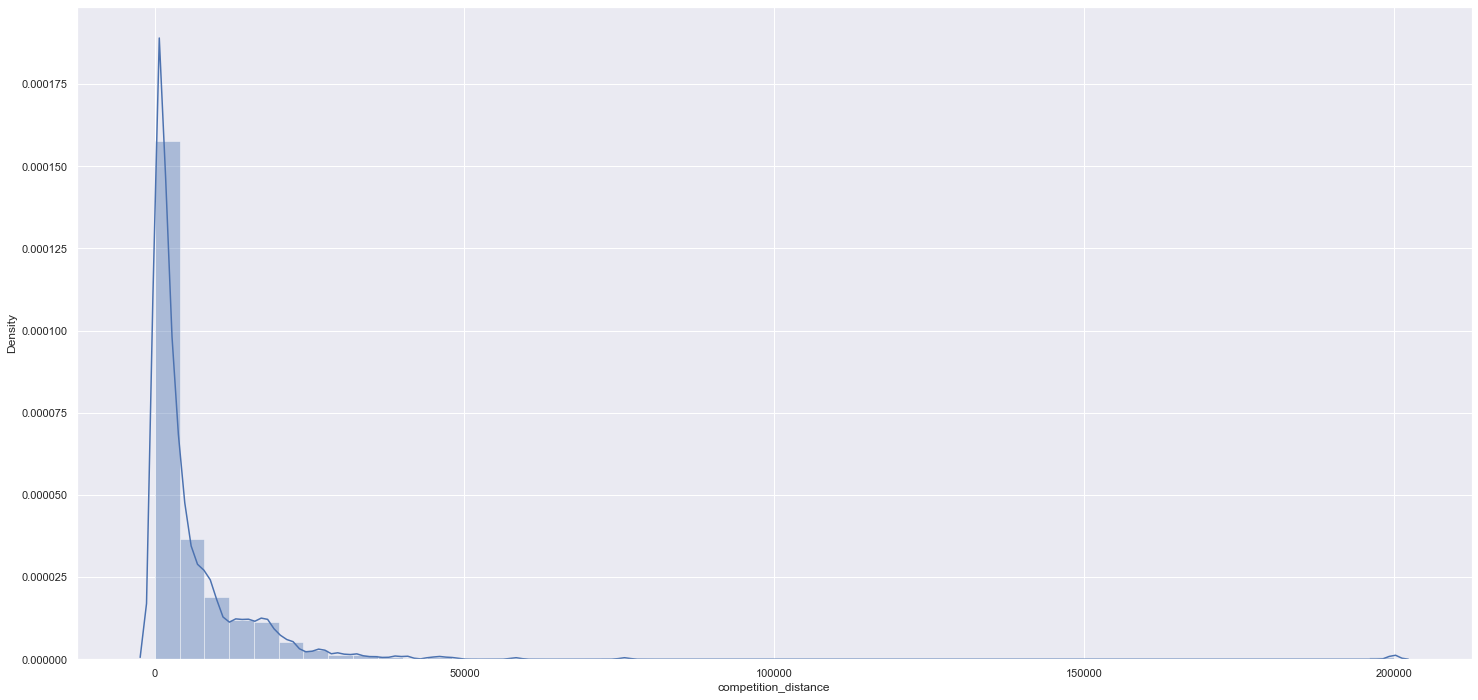

In [16]:
sns.distplot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

In [17]:
# Visualize how many attributes each column has
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

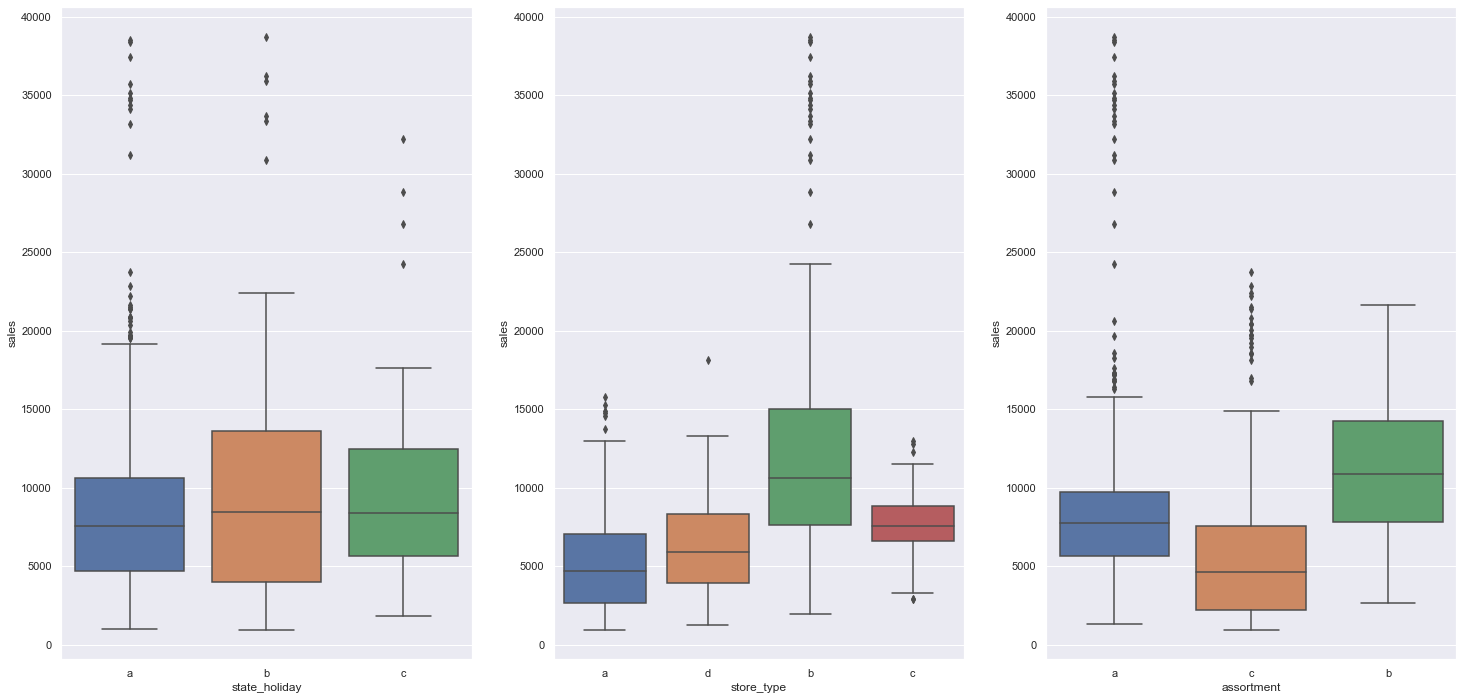

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' ,y='sales', data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type' ,y='sales', data=aux1 )

plt.subplot(1,3,3)
sns.boxplot(x='assortment' ,y='sales', data=aux1 )

# 2.0. Feature Engineering

## 2.1. Mind Map Hypothesis

In [19]:
df2 = df1.copy()

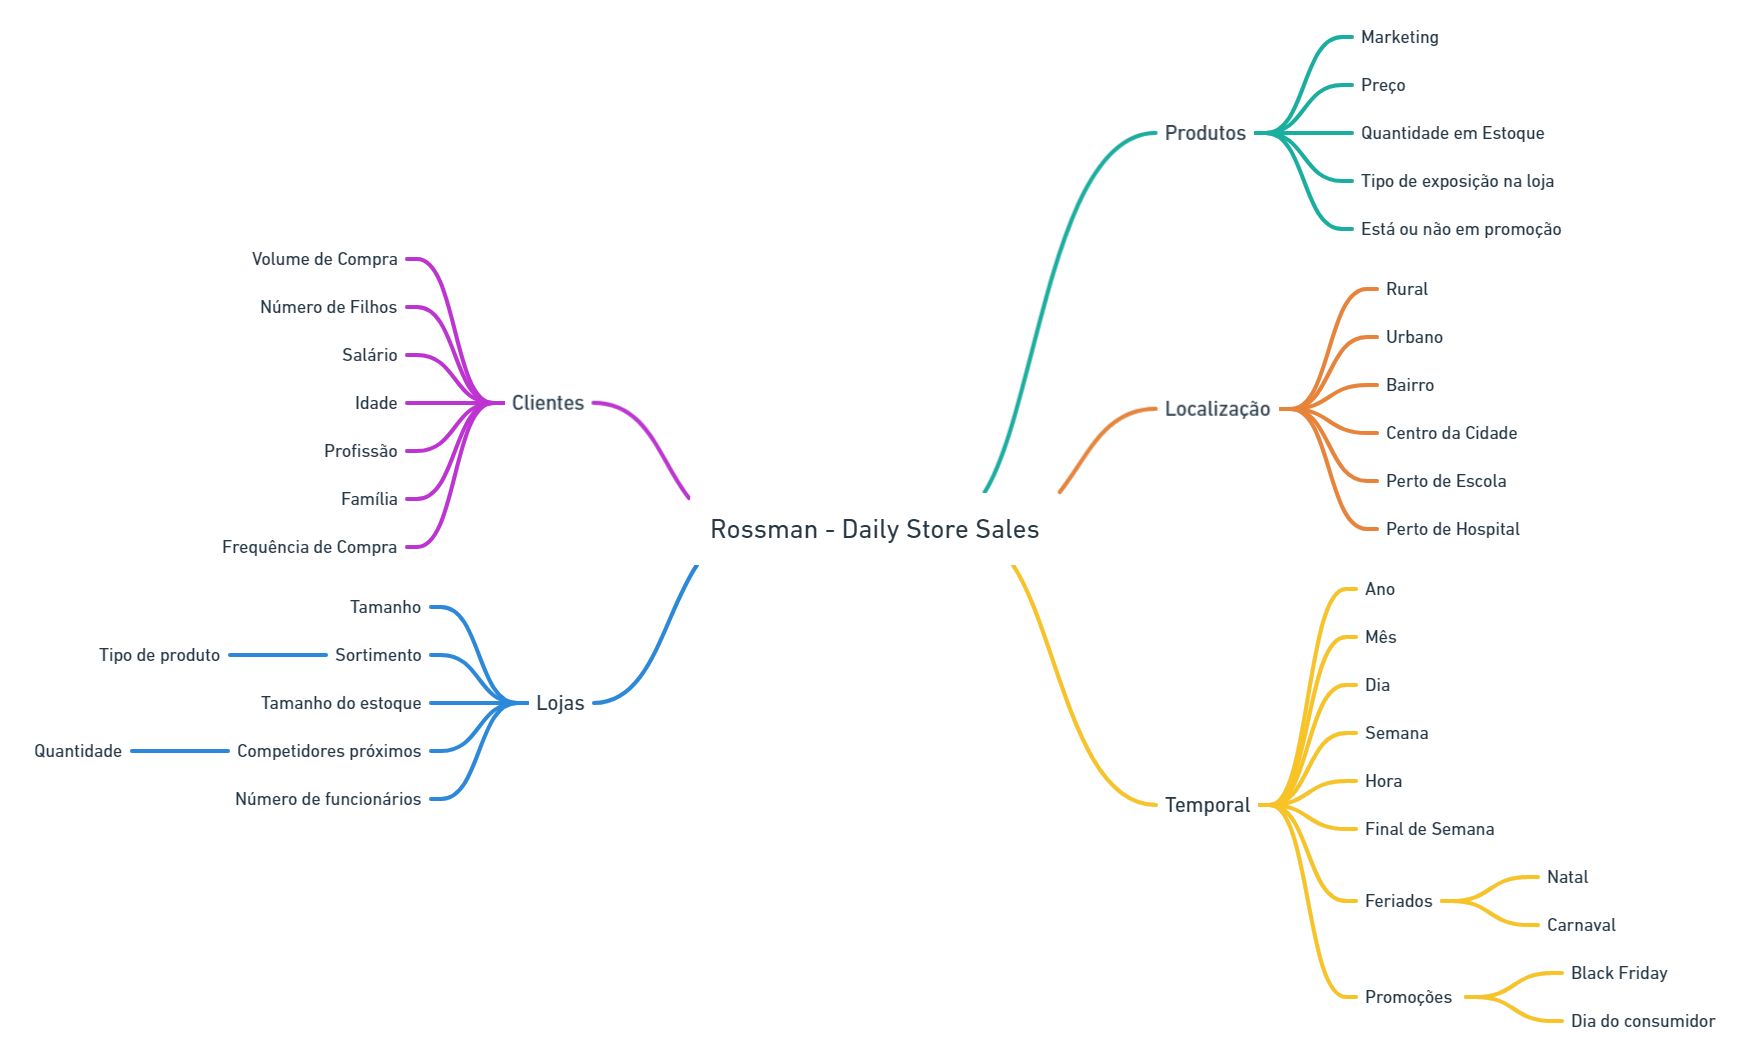

In [20]:
Image('img/MindMapRossman2.png')

## 2.2. Hypothesis Creation

### 2.2.1. Hipóteses da Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores à mais tempo deveriam vender mais

#### 2.2.2. Hipóteses do Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expõe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com promoções mais agressivas deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas com promoções mais agressivas (maiores descontos) deveriam vender mais

### 2.2.3. Hipóteses do tempo

**1.** Lojas deveriam vender mais no segundo semestre do ano

**2.** Lojas deveriam vender menos aos finais de semana.

**3.**Lojas abertas durante o feriado de Natal deveriam vender mais.

**4.**Lojas deveriam vender mais ao longo dos anos

**5.**Lojas deveriam vender mais depois do dia 10 de cada mês

**6.**Lojas deveriam vender menos durante feriados escolares.

## 2.3. lista Final de Hipóteses
Etapa de priorização de hipóteses. A ideia aqui é simples: Priorizar as hipóteses que já possuem os dados à disposição e tratados.

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas deveriam vender mais no segundo semestre do ano

**8.** Lojas deveriam vender menos aos finais de semana.

**9.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**10.** Lojas deveriam vender mais ao longo dos anos

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês

**12.** Lojas deveriam vender menos durante feriados escolares.

## 2.4. Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [22]:
# competition since
# gather 'competition_open_since_year' and 'competition_open_since_month' together and then
# subtracting it to 'date' so we can obtain how many months have passed for each store since
# competitions opened
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                  month=x['competition_open_since_month'],
                 day=1), axis=1)

# dividing by 30 so we can obtain the result as months
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30 ).apply(lambda x: x.days).astype(int)

In [23]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

# now we have to convert the 'promo_since' to datetime. This method is explained
# on the bonus video, that is not launched at the moment (26/03) 
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days = 7) )
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype(int)

In [24]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'
                                          else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
      else 'christmas' if x == 'c' else 'regular_day')

In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtragem de Variáveis

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [28]:
# stores open only
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das colunas

In [29]:
#'customers' é uma restrição do negócio, pois não teremos o input no momento da análise de quantas pessoas
# estarão nas lojas nas próximas 6 semanas
# a coluna 'open' não será mais necessária pois estará preenchida totalmente apenas com o valor '1'
# 'promo_interval' e 'month_map' são variáveis auxiliares, e não mais necessárias
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Exploratory Data Analysis

In [30]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

C:\Users\Caio\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

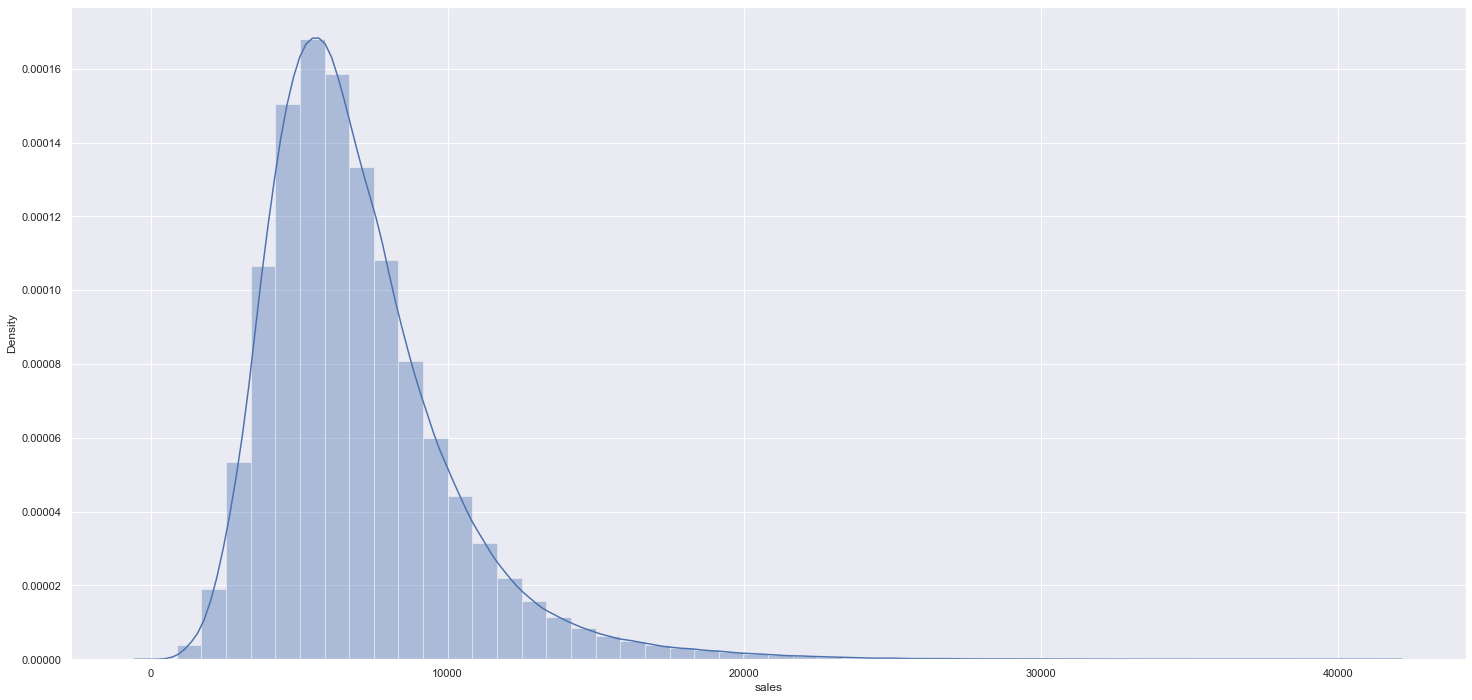

In [31]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

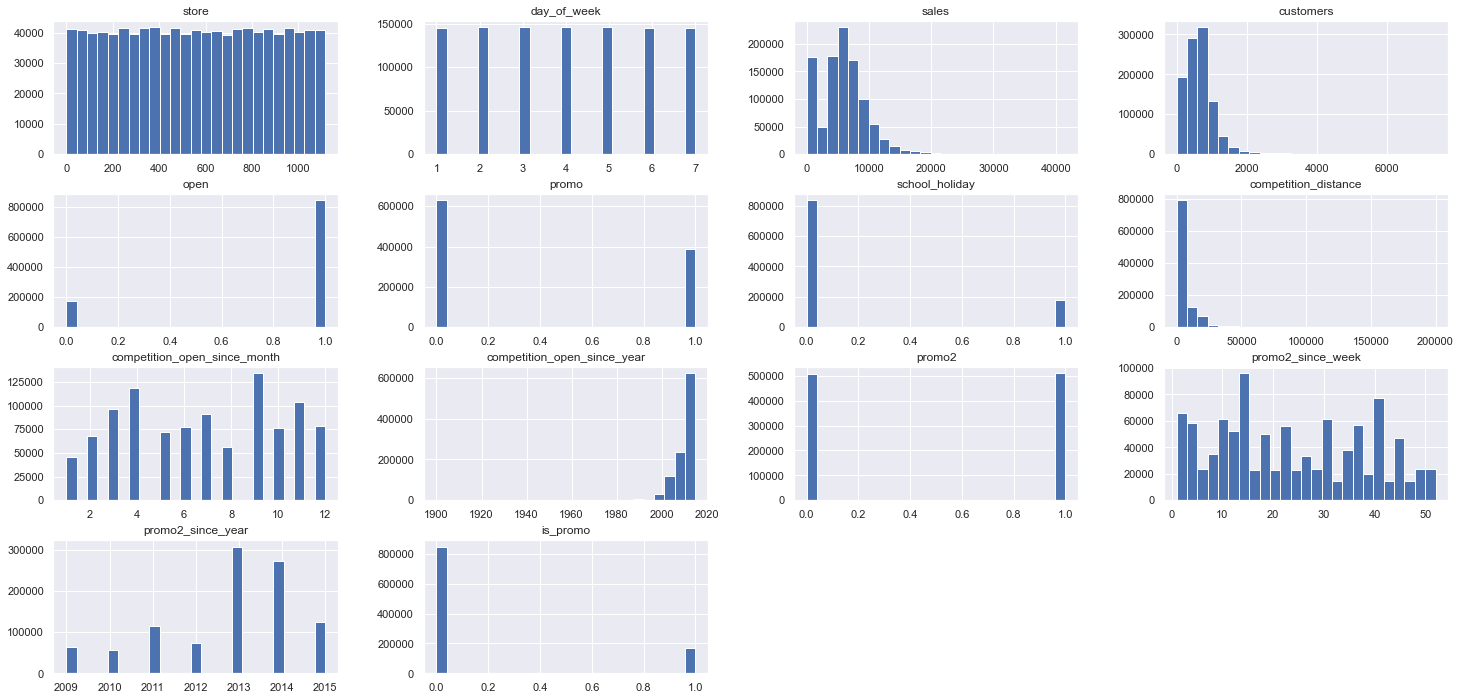

In [32]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

In [33]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

C:\Users\Caio\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Caio\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Caio\anaconda3\envs\DataScienceEmProducao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in a

<AxesSubplot:xlabel='sales', ylabel='Density'>

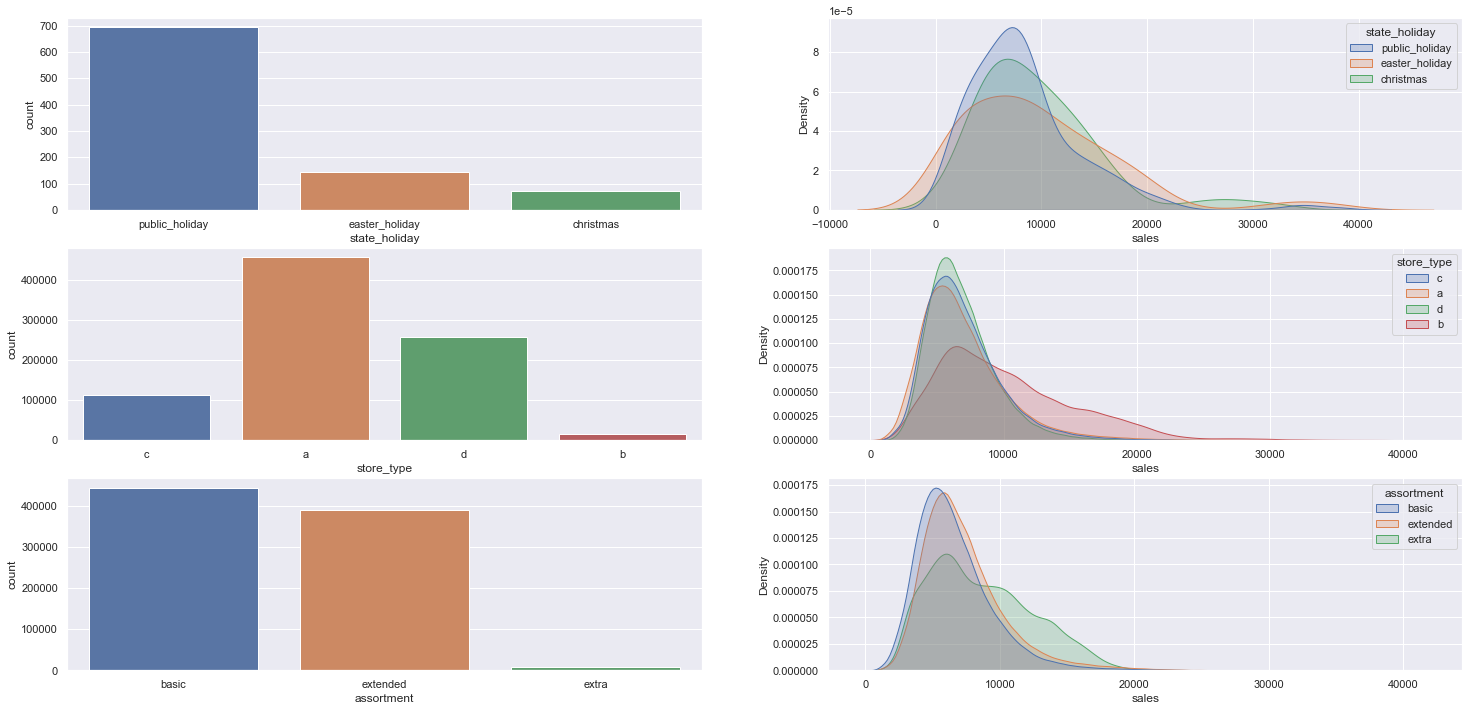

In [34]:
#state holiday
plt.subplot(3,2,1)
# Removing 'regular day' so we can visualize the impact of each holiday on sales. 
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(data = a['state_holiday'], x=a['sales'], hue = a['state_holiday'], common_norm = False, shade = True)

# way that meigarom did the grapsh
# sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
# sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
# sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store type
plt.subplot(3,2,3)
# Removing 'regular day' so we can visualize the impact of each holiday on sales. 
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(data = df4['store_type'], x = df4['sales'], hue = df4['store_type'], common_norm = False, shade = True)

# way that meigarom did the graphs
# sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
# sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
# sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
# sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

# assortment
plt.subplot(3,2,5)
# Removing 'regular day' so we can visualize the impact of each holiday on sales. 
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(data = df4['assortment'], x=df4['sales'], hue = df4['assortment'], common_norm = False, shade = True)

## 4.2. Análise Bivariada

### 4.2.1 - **H1** - Lojas com maior sortimento deveriam vender mais.
**FALSE** - Stores with larger assortments sell less

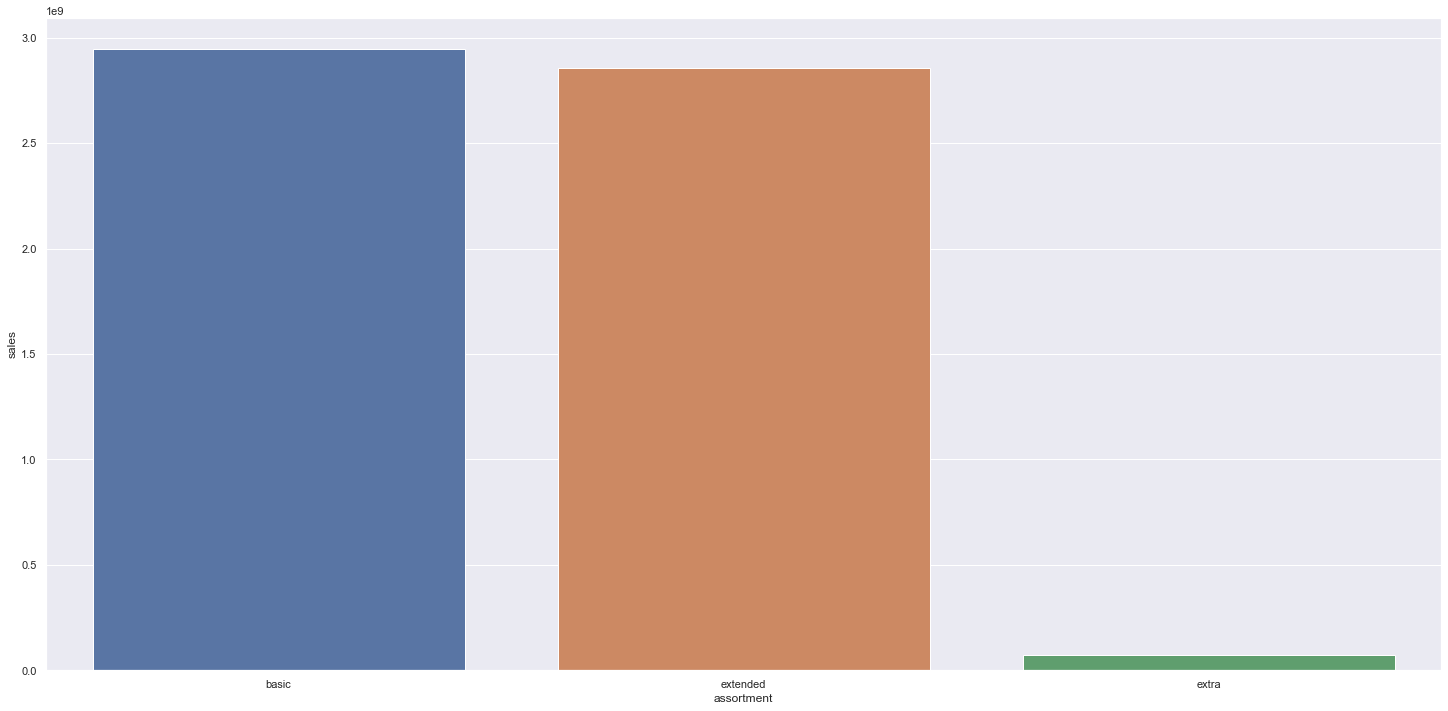

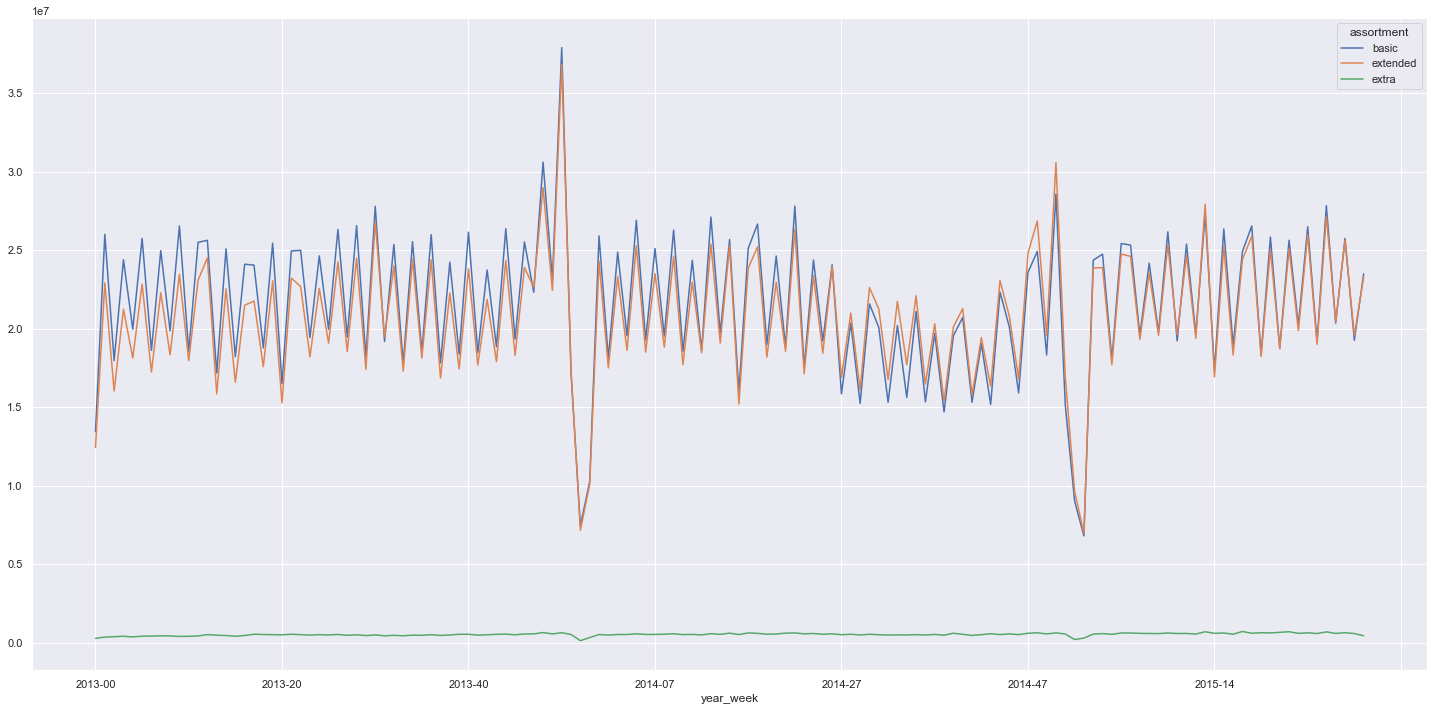

In [35]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y='sales', data = aux1)

# sum for each type of assortment for each week of year
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux3 = aux2.pivot(index='year_week',columns='assortment', values ='sales').plot()



Basically, the behavior of 'basic' and 'extended' are pretty much the same. Now, we have to examine the 'extra' assortment on another scale to verify if there's a behavior or if it's a simple line, as it seems.

<AxesSubplot:xlabel='year_week'>

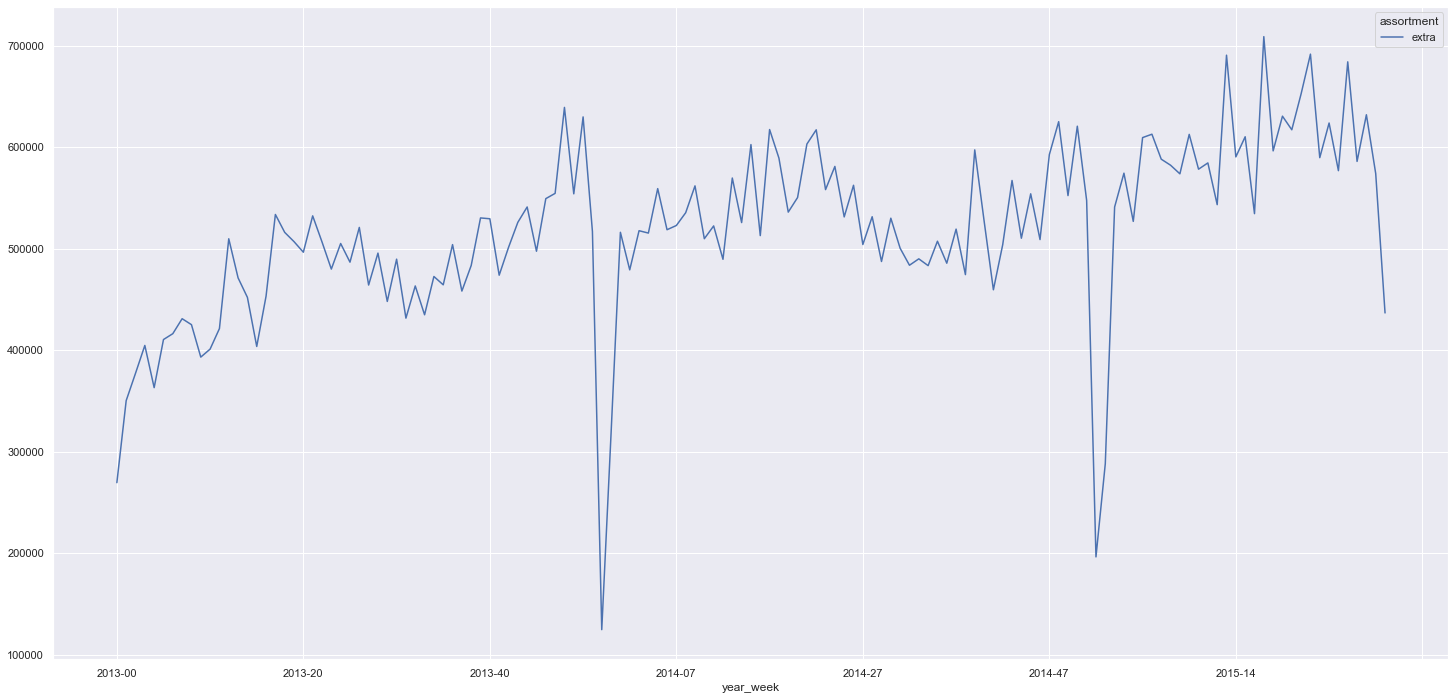

In [36]:
aux4 = aux2[aux2['assortment'] == 'extra']
aux4.pivot(index='year_week',columns='assortment', values ='sales').plot()

<AxesSubplot:xlabel='sales', ylabel='Density'>

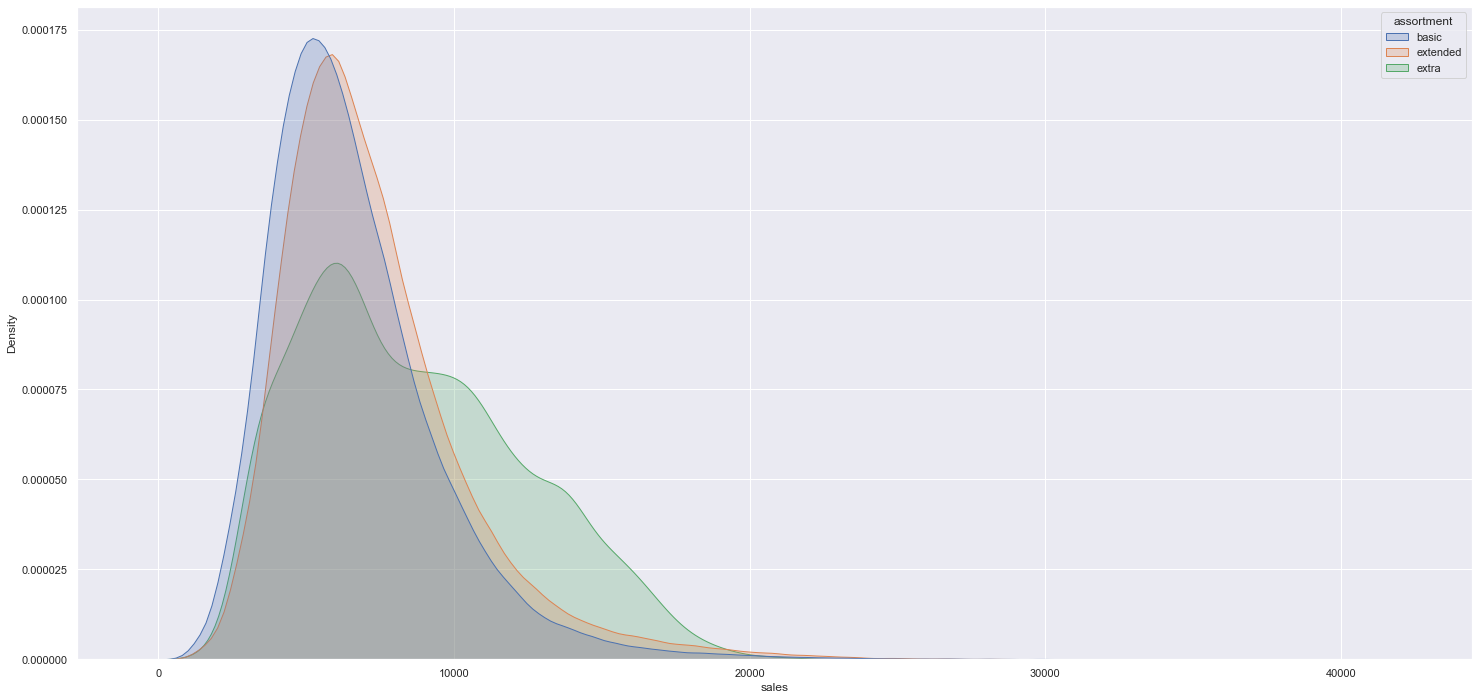

In [37]:
# plotting the 'pdf' for the assortment type
sns.kdeplot(data = df4['assortment'], x=df4['sales'], hue = df4['assortment'], common_norm = False, shade = True)

Contrary to what was imagined at first sight, there's a clearly behavior to 'extra' assortment, and it's different from what we have seen on the previous graph, to the 'basic' and 'extended' assortment. 
Besides the 'extra' assortment have a greater mean, the predictability around its median and mode are lower than the other 2 assortment types. 

In terms of the initial hypothesis, we can conclude that it's FALSE, because the smaller the assortment, the greater the sales, according to the analysis.
This variable will probably will be relevant for the machine learning algorithm, based on it's different behavior and seasonality.

### 4.2.2 - **H2** - Lojas com competidores mais próximos deveriam vender menos
**FALSE** - Stores with closer competitors sell more.

<AxesSubplot:>

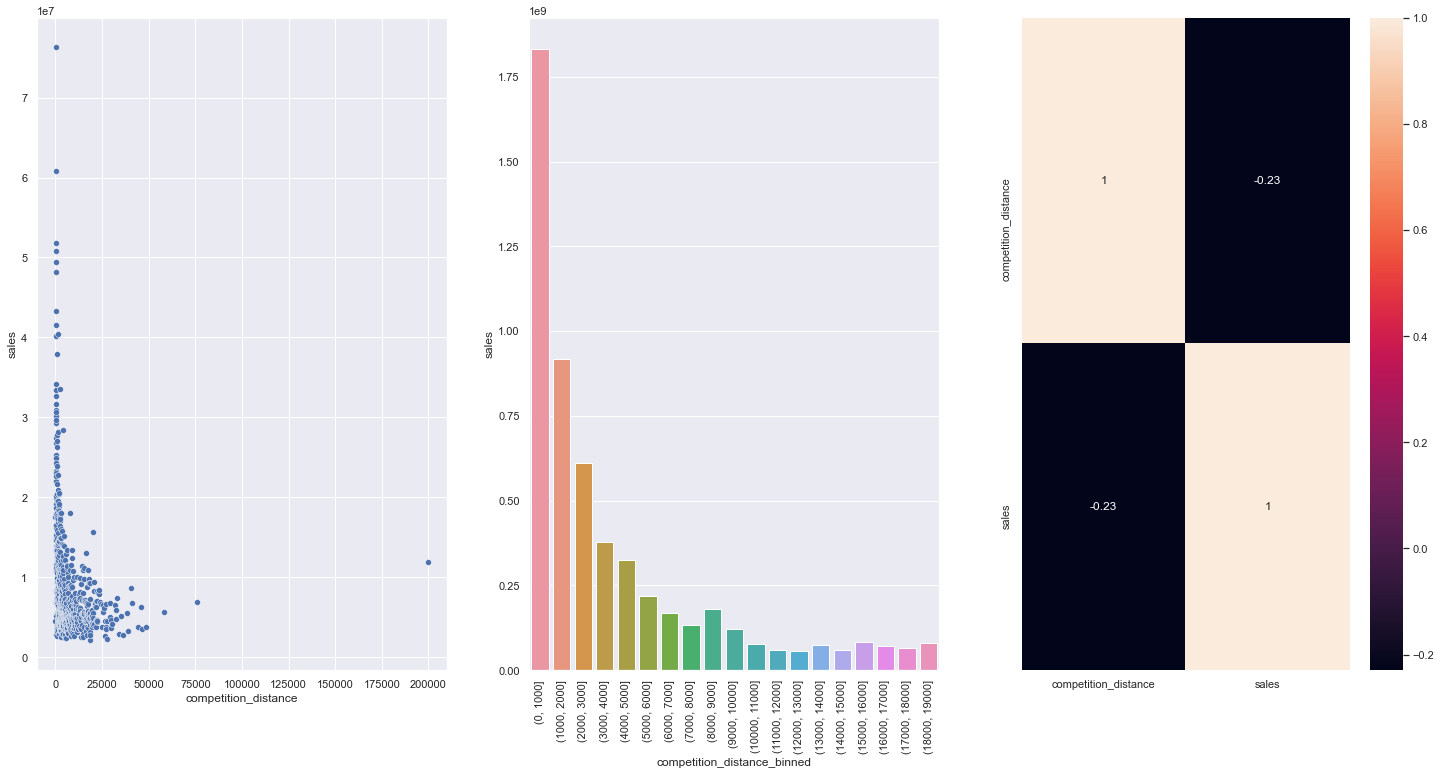

In [52]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
# visualizing the data concentration
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

# create a variable to support the plot 'competition_distance' x 'sales'
bins = list(np.arange(0,20000,1000))

plt.subplot(1,3,2)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

It's clear from the 2 first graphs that the closer the distance to a competitor, the greater is the sales. The correlation heat map also indicates that there's a negative correlation between 'competition_distance' and 'sales'

### 4.2.3 - **H3** - Lojas com competidores à mais tempo deveriam vender mais

<AxesSubplot:>

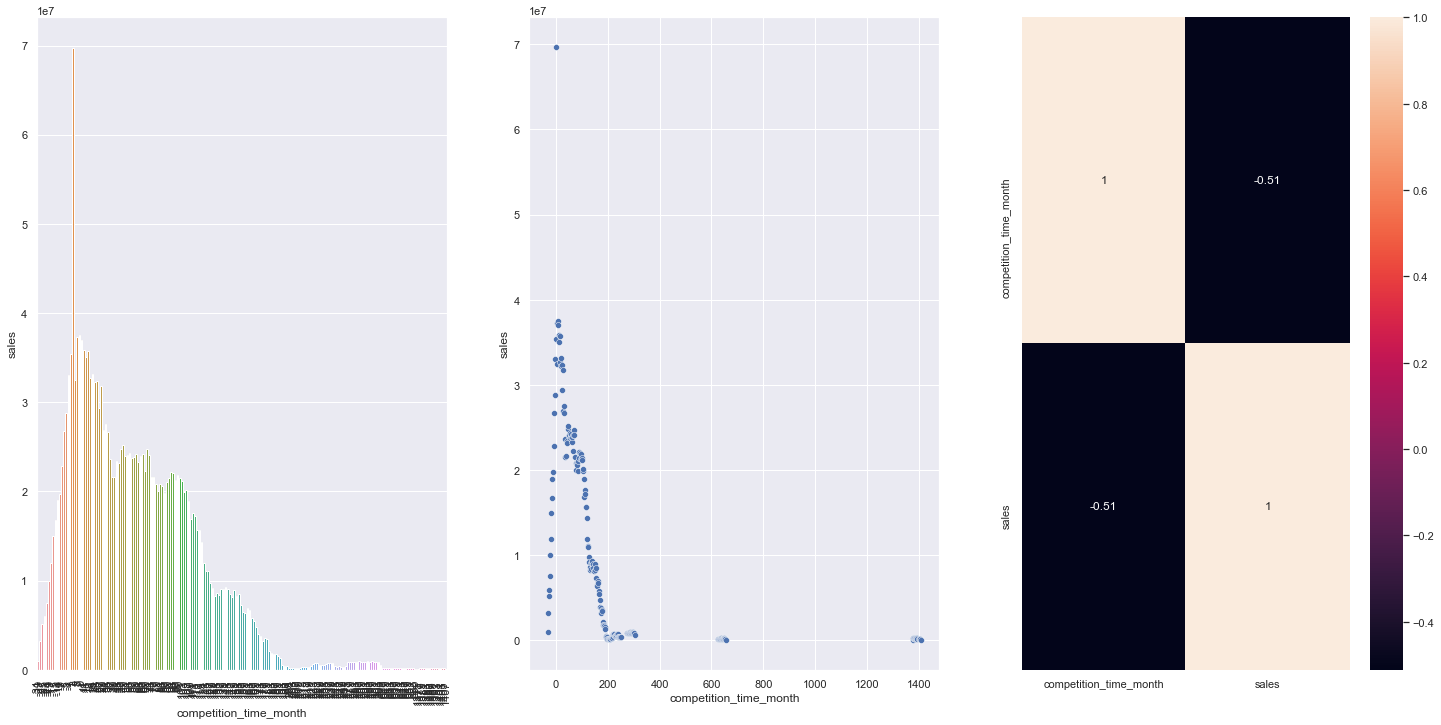

In [65]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 2500) & (aux1['competition_time_month']) != 0]
sns.barplot(x = 'competition_time_month', y ='sales', data = aux2)
plt.xticks(rotation = 90)

# visualizing the data concentration
plt.subplot(1,3,2)
sns.scatterplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method = 'pearson'), annot = True)

In [56]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
